In [1]:
import string
import re
import random

from nltk.translate.bleu_score import sentence_bleu
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
from torchmetrics.functional import accuracy

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [2]:
data_path = "rus.txt"
data = pd.read_table(data_path,  usecols=range(2), names=['eng', 'rus'])
data.sample(5)

,eng,rus
293576,I saw your brother the other day.,Я тут как-то видел твоего брата.
316800,Your strategy seems to be working.,"Похоже, твоя стратегия работает."
67229,Hatred is our enemy.,Ненависть — наш враг.
404616,Tom should have discussed the matter with me.,Тому надо было обсудить этот вопрос со мной.
208198,I told Tom not to come here.,Я сказала Тому не приходить сюда.


In [3]:
data.shape

(440219, 2)

In [4]:
samples = 15000
train_set = data.sample(samples)

train_set.shape

(15000, 2)

Make everything lowercase

In [5]:
train_set.eng = train_set.eng.apply(lambda x: x.lower())
train_set.rus = train_set.rus.apply(lambda x: x.lower())

Remove punctuation - https://stackoverflow.com/questions/33047818/remove-punctuation-for-each-row-in-a-pandas-data-frame

In [6]:
train_set.eng = train_set.eng.apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
train_set.rus = train_set.rus.apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

Strip

In [7]:
train_set.eng = train_set.eng.apply(lambda x: x.strip())
train_set.rus = train_set.rus.apply(lambda x: x.strip())

Remove digits

In [8]:
remove_digits = str.maketrans('', '', string.digits)
train_set.eng=train_set.eng.apply(lambda x: x.translate(remove_digits))
train_set.rus=train_set.rus.apply(lambda x: x.translate(remove_digits))

eng_lengths = train_set.eng.str.split(' ')
max_eng = eng_lengths.str.len().max()
rus_lengths = train_set.rus.str.split(' ')
max_rus = rus_lengths.str.len().max()
MAX_L= max(max_rus,max_eng) + 1

In [9]:
end_token = "E_"
start_token = "S_"
end_index = 0
start_index = 1

In [10]:
class Vectorizer:
    def __init__(self):
        self.word2index = {end_token: end_index, start_token: start_index}
        self.word2count = {}
        self.index2word = {end_index: end_token, start_index: start_token}
        self.n_words = 2 #E_ and S_
    
    def addToVector(self, line):
        for w in line.split(' '):
            if w not in self.word2index:
                self.word2index[w] = self.n_words
                self.word2count[w] = 1
                self.index2word[self.n_words] = w
                self.n_words += 1
            else:
                self.word2count[w] += 1
                
    def vectorize_line(self, line):
        return [self.word2index[w] for w in line.split(' ')]

In [11]:
rus_vec = Vectorizer()
eng_vec = Vectorizer()

for rus,eng in zip(train_set.rus,train_set.eng):
    rus_vec.addToVector(rus)
    eng_vec.addToVector(eng)

In [12]:
print(eng_vec.n_words)

4926


In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.initial_hidden = torch.zeros(1,1,self.hidden_size,device=device)

    def forward(self, x, hidden):
        embedded = self.embedding(x).view(1, 1, -1) #fill
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

Using GRU

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1, max_l=MAX_L):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = dropout
        self.max_l = max_l

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_l)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.initial_hidden=torch.zeros(1, 1, self.hidden_size, device=device)

    def forward(self, input, hidden,enc_outs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 enc_outs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

Convert pair of sentences to torch tensor

In [15]:
def prepare_tensors(pair):
    eng_s=pair.iloc[0]['eng'] + ' ' + end_token
    rus_s=pair.iloc[0]['rus'] + ' ' + end_token
    input_t=torch.tensor(eng_vec.vectorize_line(eng_s), dtype=torch.long, device=device).view(-1, 1)
    target_t=torch.tensor(rus_vec.vectorize_line(rus_s), dtype=torch.long, device=device).view(-1, 1)
    return input_t,target_t

Functions to measure time for n iters

In [16]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%02dm %02ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return asMinutes(s)

In [17]:
def output_to_words(output):
    words=[]
    for vec in output:
        top_val, top_i = vec.data.topk(1)
        if top_i.item() == end_index: 
            break
        words.append(rus_vec.index2word[top_i.item()])
    return words

def target_to_words(target):
    words=[]
    for i in target:
        words.append(rus_vec.index2word[i.item()])
    return words

In [18]:
def bleu(output,target):
    weights = [1,1,1,1]
    if len(output) == 0: 
        return 0
    if len(output)<4:
        for i in range(4-len(output)):
            weights[-i-1]=0
    res = sentence_bleu([output], target, weights=tuple(weights))
    return res

In [19]:
def train(input_t, target_t, encoder, decoder, enc_opt, dec_opt, loss_func, max_l=MAX_L):
    
    input_l = input_t.size(0)
    target_l = target_t.size(0)
    loss = 0
    acc = 0 
    
    enc_opt.zero_grad()
    dec_opt.zero_grad()
    enc_hidden = encoder.initial_hidden
    enc_outs = torch.zeros(max_l, encoder.hidden_size, device=device)
        
    for i in range(input_l):
        enc_out, enc_hidden = encoder(input_t[i], enc_hidden)
        enc_outs[i] = enc_out[0, 0]
    dec_in = torch.tensor([[start_index]],device=device) #we pass start as initial input
    dec_hidden = enc_hidden
    dec_outs = []
    
    for i in range(target_l):
        dec_out, dec_hidden, dec_attention = decoder(dec_in, dec_hidden, enc_outs)
        loss += loss_func(dec_out,target_t[i])
        acc += accuracy(dec_out, target_t[i])
        dec_in = target_t[i] #teacher forcing
        dec_outs.append(dec_out)
       
    
    target_w = target_to_words(target_t)
    output_w = output_to_words(dec_outs)

    bleu_acc = bleu(output_w, target_w)    
      
    loss.backward()
    enc_opt.step()
    dec_opt.step()
    
    return loss.item()/target_l, bleu_acc, acc/target_l

In [20]:
def iterations(encoder, decoder, n, print_every=10000, plot_every=100, lr=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    print_bleu_total=0
    print_acc_total = 0
    
    enc_opt = optim.SGD(encoder.parameters(), lr=lr)
    dec_opt = optim.SGD(decoder.parameters(), lr=lr)
    training_pairs = [prepare_tensors(train_set.sample(1)) for i in range(n)]
    loss_func = nn.NLLLoss()
    
    for i in range(1,n+1):
        training_pair = training_pairs[i-1]
        input_t = training_pair[0]
        target_t = training_pair[1]
        
        loss, bleu_acc, acc = train(input_t, target_t, encoder, decoder, enc_opt, dec_opt, loss_func)
        print_loss_total += loss
        plot_loss_total += loss
        print_bleu_total += bleu_acc
        print_acc_total += acc
        
        if i % print_every == 0:
            print_loss_avg = print_loss_total/print_every
            print_loss_total = 0
            print_bleu = print_bleu_total / print_every
            print_bleu_total=0
            print_acc =  print_acc_total / print_every
            print_acc_total=0
            print('time:{} iteration: {} {:.1f}% loss: {:.4f} bleu acc: {:.4f} acc: {:.4f}'.format(timeSince(start), i, i / n * 100, print_loss_avg, print_bleu, print_acc))
            
        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    return plot_losses

In [21]:
hidden_size = 256
N=100000
encoder = EncoderRNN(eng_vec.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, rus_vec.n_words).to(device)

plot_losses = iterations(encoder, decoder, N, print_every=10000)

C:\Users\mente\anaconda3\envs\torch_learning\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mente\anaconda3\envs\torch_learning\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mente\anaconda3\envs\torch_learning\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

time:04m 58s iteration: 10000 10.0% loss: 5.2574 bleu acc: 0.0010 acc: 0.3074
time:08m 44s iteration: 20000 20.0% loss: 4.1653 bleu acc: 0.0031 acc: 0.4101
time:12m 33s iteration: 30000 30.0% loss: 3.5668 bleu acc: 0.0061 acc: 0.4630
time:16m 20s iteration: 40000 40.0% loss: 3.1268 bleu acc: 0.0115 acc: 0.5047
time:20m 06s iteration: 50000 50.0% loss: 2.7935 bleu acc: 0.0168 acc: 0.5374
time:23m 55s iteration: 60000 60.0% loss: 2.4945 bleu acc: 0.0239 acc: 0.5666
time:27m 56s iteration: 70000 70.0% loss: 2.2975 bleu acc: 0.0316 acc: 0.5885
time:31m 44s iteration: 80000 80.0% loss: 2.1018 bleu acc: 0.0370 acc: 0.6107
time:35m 27s iteration: 90000 90.0% loss: 2.0349 bleu acc: 0.0395 acc: 0.6134
time:39m 09s iteration: 100000 100.0% loss: 1.9610 bleu acc: 0.0401 acc: 0.6153


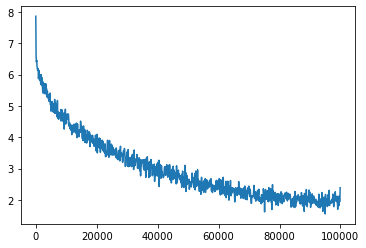

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(0,N,100),plot_losses)

In [26]:
def evaluate(encoder, decoder, sentence, max_l=MAX_L):
    with torch.no_grad():
        input_t = torch.tensor(eng_vec.vectorize_line(sentence), dtype=torch.long, device=device).view(-1, 1)
        input_l = input_t.size()[0]
        enc_hidden = encoder.initial_hidden
        enc_outs = torch.zeros(max_l, encoder.hidden_size, device=device)
        for i in range(input_l):
            enc_out, enc_hidden = encoder(input_t[i], enc_hidden)
            enc_outs[i]=enc_out[0,0]
        
        dec_in = torch.tensor([[start_index]], device=device)
        dec_hidden = enc_hidden
        dec_words=[]
        for i in range(max_l):
            dec_out, dec_hidden, dec_attention = decoder(dec_in, dec_hidden, enc_outs)
            top_v, top_i = dec_out.data.topk(1)
            if top_i.item() == 0: 
                dec_words.append(end_token)
                break
            else:
                dec_words.append(rus_vec.index2word[top_i.item()])
            dec_in = top_i.squeeze().detach()
        
        return dec_words

In [27]:
def evaluateRandomly(encoder, decoder, n=10):
    pairs = train_set.sample(n)
    for rus,eng in zip(pairs.rus,pairs.eng):
        print('Input: ', eng)
        print('Target: ', rus)
        output_w = evaluate(encoder, decoder, eng)
        output_sentence = ' '.join(output_w)
        print('Output: ', output_sentence)
        del output_w[-1]
        target_w = rus.split(' ')
        print('Bleu: ', bleu(output_w, target_w))
        print('')

In [28]:
evaluateRandomly(encoder, decoder)

Input:  we must respect toms decision
Target:  мы должны уважать решение тома
Output:  мы должны уважать тома E_
Bleu:  2.96676514467623e-309

Input:  i found a strange object lying on the road
Target:  я нашёл странный предмет лежащий на дороге
Output:  я забыл на своего отца E_
Bleu:  0.0

Input:  the child burst out crying
Target:  ребёнок расплакался
Output:  в шесть E_
Bleu:  0

Input:  i have two sons one is in boston and the other is in chicago
Target:  у меня два сына один в бостоне другой в чикаго
Output:  у меня в бостоне и одна в бостоне и одна же E_
Bleu:  0.0

Input:  i bought a book about animals
Target:  я купила книгу про животных
Output:  я прочёл книгу про E_
Bleu:  0.0

Input:  they wont come back
Target:  они не вернутся
Output:  они не так E_
Bleu:  7.41691286169047e-309

Input:  we want to go to australia
Target:  мы хотим поехать в австралию
Output:  мы хотим поехать в австралию E_
Bleu:  1.0

Input:  you were supposed to be there
Target:  предполагалось что вы т

C:\Users\mente\anaconda3\envs\torch_learning\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mente\anaconda3\envs\torch_learning\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mente\anaconda3\envs\torch_learning\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

Output:  ты рассказал в бостоне говорил E_
Bleu:  0

Input:  turn around
Target:  обернись
Output:  у неё E_
Bleu:  0

